In [20]:
#Importar el drive para usar el dataset y carga de librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from seaborn import violinplot
from sklearn.preprocessing import LabelEncoder


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Ruta del archivo en Google Drive
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
counter = pd.read_csv(name, sep=";")

Saving Anexo ET_demo_round_traces_2022.csv to Anexo ET_demo_round_traces_2022 (1).csv


<ipython-input-21-e48695eea88a>:6: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  counter = pd.read_csv(name, sep=";")


## Fase 3: Data Preparation

In [22]:
counter_backup = counter.copy()

In [23]:
counter_backup.drop(columns=['FirstKillTime'], inplace=True)
counter_backup.drop(columns=['TimeAlive'], inplace=True)
counter_backup.drop(columns=['TravelledDistance'], inplace=True)

### Eliminacion de datos atipicos

In [24]:
counter_backup.drop(counter_backup[counter_backup['MatchKills'] > 28].index, inplace=True)
counter_backup.shape

(78995, 27)

In [25]:
counter_backup.drop(counter_backup[counter_backup['MatchAssists'] > 8].index, inplace=True)
counter_backup.shape

(78710, 27)

In [26]:
label_encoder = LabelEncoder()
counter_backup['Team'] = label_encoder.fit_transform(counter_backup['Team'])
counter_backup['Map'] = label_encoder.fit_transform(counter_backup['Map'])

In [27]:
counter_backup['Map'].unique()

array([1, 3, 2, 0])

### Transformar datos booleanos

In [28]:
counter_backup.RoundWinner = counter_backup.RoundWinner.astype(bool)
counter_backup.MatchWinner = counter_backup.MatchWinner.astype(bool)
# Conversion
counter_backup.RoundWinner.replace({True: 1, False: 0}, inplace=True)
counter_backup.MatchWinner.replace({True: 1, False: 0}, inplace=True)
counter_backup.Survived.replace({True: 1, False: 0}, inplace=True)

<ipython-input-28-4a422bf30625>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  counter_backup.RoundWinner.replace({True: 1, False: 0}, inplace=True)
<ipython-input-28-4a422bf30625>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  counter_backup.RoundWinner.replace({True: 1, False: 0}, inplace=True

In [29]:
# Revisiom
counter_backup.info()
# Vista previa
counter_backup.head()

<class 'pandas.core.frame.DataFrame'>
Index: 78710 entries, 0 to 79156
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   78710 non-null  int64  
 1   Map                          78710 non-null  int64  
 2   Team                         78710 non-null  int64  
 3   InternalTeamId               78710 non-null  int64  
 4   MatchId                      78710 non-null  int64  
 5   RoundId                      78710 non-null  int64  
 6   RoundWinner                  78710 non-null  int64  
 7   MatchWinner                  78710 non-null  int64  
 8   Survived                     78710 non-null  int64  
 9   AbnormalMatch                78710 non-null  bool   
 10  RLethalGrenadesThrown        78710 non-null  int64  
 11  RNonLethalGrenadesThrown     78710 non-null  int64  
 12  PrimaryAssaultRifle          78710 non-null  float64
 13  PrimarySniperRifle   

,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,...,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,600,1,1,1,4,1,1,1,0,False,...,0,0,0,0,750,4400,0,0,0,0
1,601,1,1,1,4,1,1,1,0,False,...,0,0,0,0,800,4400,0,0,0,0
2,602,1,1,1,4,1,1,1,0,False,...,0,0,0,0,1000,4400,0,0,0,0
3,603,1,1,1,4,1,1,1,0,False,...,0,0,0,0,850,4400,0,0,0,0
4,604,1,1,1,4,1,1,1,1,False,...,0,0,0,0,1000,4400,0,0,0,0


In [30]:
# Limitar numero de rondas
counter_backup = counter_backup[(counter_backup['RoundId'] >= 1) & (counter_backup['RoundId'] <= 30)]

counter_backup['RoundId'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

### Regresion lineal multiple

COMPARACIÓN DE RENDIMIENTO
-------------------------
Métrica		Entrenamiento	Prueba	Diferencia
R²		0.304		0.298		0.006
MAE		0.39		0.39		-0.00


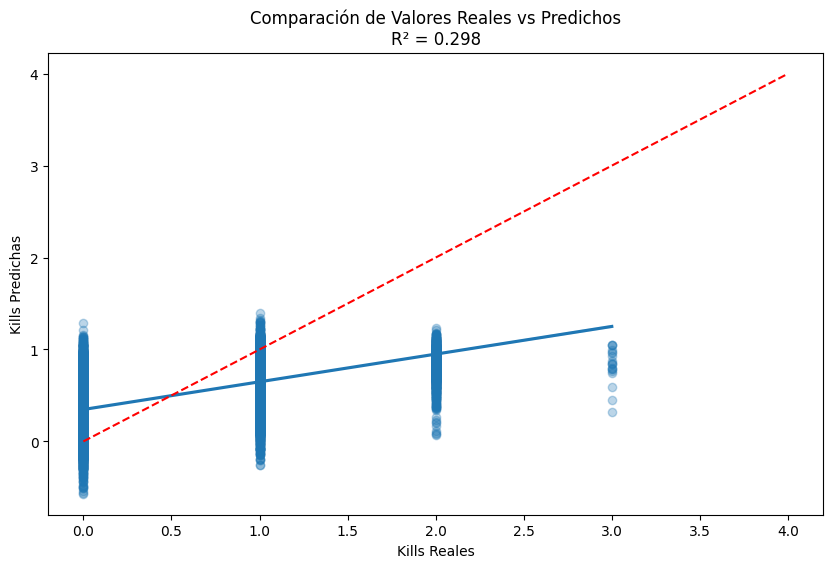

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

X = counter_backup.drop(['RLethalGrenadesThrown','RoundKills'], axis=1)
y = counter_backup['RLethalGrenadesThrown']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo = LinearRegression()
modelo.fit(X_train, y_train)

train_pred =  modelo.predict(X_train)
test_pred = modelo.predict(X_test)

print("COMPARACIÓN DE RENDIMIENTO")
print("-------------------------")
print(f"Métrica\t\tEntrenamiento\tPrueba\tDiferencia")
print(f"R²\t\t{r2_score(y_train, train_pred):.3f}\t\t{r2_score(y_test, test_pred):.3f}\t\t{r2_score(y_train, train_pred) - r2_score(y_test, test_pred):.3f}")
print(f"MAE\t\t{mean_absolute_error(y_train, train_pred):.2f}\t\t{mean_absolute_error(y_test, test_pred):.2f}\t\t{mean_absolute_error(y_train, train_pred) - mean_absolute_error(y_test, test_pred):.2f}")


# Gráfico de valores reales vs predichos
plt.figure(figsize=(10,6))
sns.regplot(x=y_test, y=test_pred, scatter_kws={'alpha':0.3})
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Kills Reales')
plt.ylabel('Kills Predichas')
plt.title('Comparación de Valores Reales vs Predichos\nR² = {:.3f}'.format(r2_score(y_test, test_pred)))
plt.show()